# GEMS LCMAP Usage Example

## Set up an HTTP client using Python's requst library
We use a `Session` object to store our API key and automatically include it in the header for each request.

Note that we have a `api_key.py` file in the Exchange-Notebooks directory. The file contains only the below line.
```
api_key = 'SECRET'
```

In [1]:
from requests import Session
import pandas as pd
pd.options.display.max_colwidth = 500
from os import environ as os_env
import rasterio
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import sys
sys.path.append('..')
from api_key import key


s = Session()
s.headers.update({'apikey': key})
landcover_url = "https://exchange-1.gems.msi.umn.edu/landcover/v2"

## Get description for available layers
Only one layer for this product is available: LCMAP Primary Land Cover  

LCMAP classes: 
1. Developed 
2. Cropland
3. Grass/Shrub
4. TreeCover
5. Water
6. Wetland
7. Ice/Snow
8. Barren (8)

In [2]:
res = s.get(landcover_url+"/lcmap-1.2/layer")
layers = pd.json_normalize(res.json())
layers

,name,units,description,discrete,id
0,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",True,251


## Access and vizualize raster data
The following example demonstrates a wildland-urban interface land cover changes after a wildfire near Paradise, CA in 2018.

### List available objects within the area of interest

In [3]:
area_of_interest = "-121.67,39.73,-121.52,39.85"
params = {
    "bbox": area_of_interest,
    "limit": 36
}
res = s.get(landcover_url+"/lcmap-1.2/object/search", params=params)

df = pd.json_normalize(res.json())
df.head()

,id,grid_id,t_ranges,t_key,t_description,name,units,description,layer_id
0,187316,5,"[{'begin': '2019', 'end': '2020'}]",None,None,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",251
1,187304,5,"[{'begin': '2007', 'end': '2008'}]",None,None,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",251
2,187310,5,"[{'begin': '2013', 'end': '2014'}]",None,None,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",251
3,187306,5,"[{'begin': '2009', 'end': '2010'}]",None,None,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",251
4,187299,5,"[{'begin': '2002', 'end': '2003'}]",None,None,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",251


### Vizualize raster data for years of interest

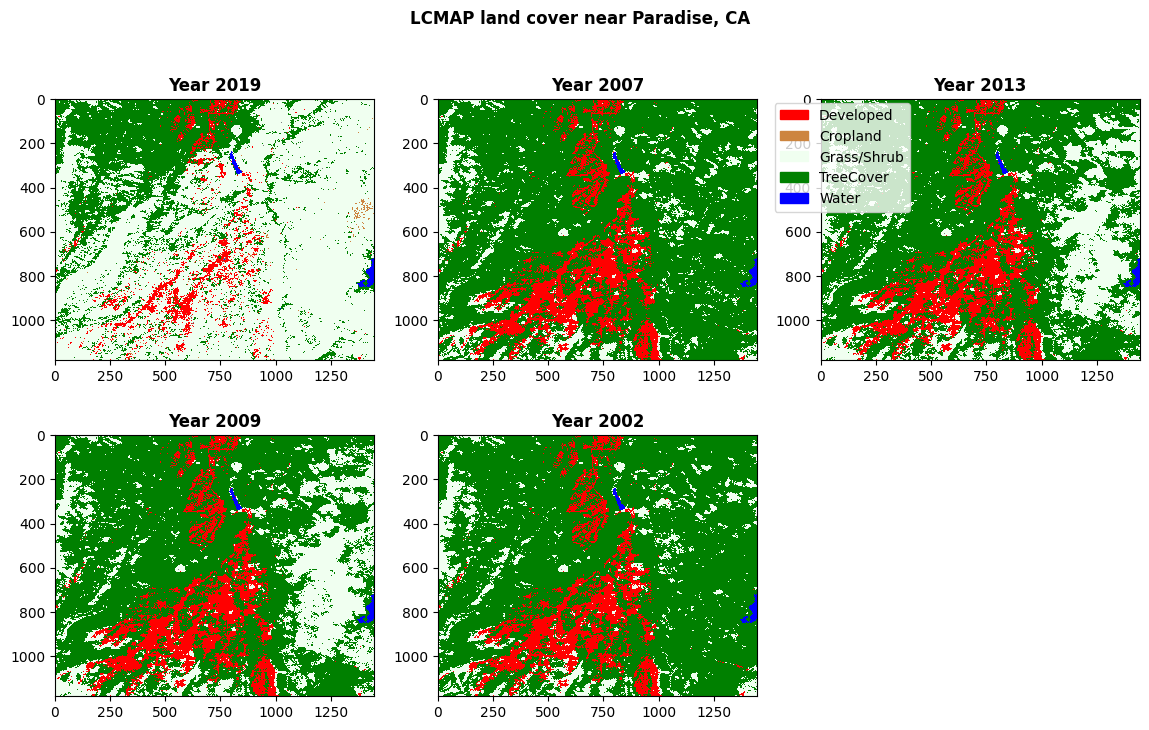

In [4]:
object_ids_of_interest = df.head().id.values

width = 5
height = 5
rows = 2
cols = 3
axes = []
fig = plt.figure(figsize=(14,8))
cmap = ListedColormap(["white", "red", "peru", "honeydew", "green", 
                       "blue", "lightblue", "snow", "grey"])

for index, object_id in zip(range(rows*cols), object_ids_of_interest):
    res = s.get(landcover_url + f"/lcmap-1.2/object/{object_id}")
    year = res.json()["t_ranges"][0]['begin']
    res = s.get(landcover_url + f"/lcmap-1.2/object/{object_id}/raster", params=params)
    raster = res.content
    with rasterio.MemoryFile(raster) as memfile:
        with memfile.open() as dataset:
            data = dataset.read(1)
            values = np.unique(data.ravel())
            axes.append( fig.add_subplot(rows, cols, index+1))
            subplot_title=(f"Year {year}")
            axes[-1].set_title(subplot_title, weight="bold")
            plt.imshow(data, interpolation="none", cmap=cmap)

developed_l = mpatches.Patch(color="red", label="Developed")
crop_l = mpatches.Patch(color="peru", label="Cropland")
grass_l = mpatches.Patch(color="honeydew", label="Grass/Shrub")
tree_l = mpatches.Patch(color="green", label="TreeCover")
water_l = mpatches.Patch(color="blue", label="Water")
plt.legend(
    handles=[
        developed_l,
        crop_l,
        grass_l,
        tree_l,
        water_l
    ],
    bbox_to_anchor=(1.5, 2.3)
)
plt.suptitle("LCMAP land cover near Paradise, CA", weight="bold")
plt.show()

## Obtain raster value count
This examples illustrates temporal trends in land cover changes near ONeill, NE (agricultural expansion and decrease in grassland cover).

### List available objects within the area of interest

In [5]:
area_of_interest = "-98.67,42.49,-98.54,42.55"
params = {
    "bbox": area_of_interest,
    "limit": 36
}
res = s.get(landcover_url + "/lcmap-1.2/object/search", params=params)
df = pd.json_normalize(res.json())
df.head()

,id,grid_id,t_ranges,t_key,t_description,name,units,description,layer_id
0,187316,5,"[{'begin': '2019', 'end': '2020'}]",None,None,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",251
1,187304,5,"[{'begin': '2007', 'end': '2008'}]",None,None,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",251
2,187310,5,"[{'begin': '2013', 'end': '2014'}]",None,None,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",251
3,187306,5,"[{'begin': '2009', 'end': '2010'}]",None,None,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",251
4,187299,5,"[{'begin': '2002', 'end': '2003'}]",None,None,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",251


### Get value count for each land cover class
Below we use `valuecount` endpoint to determine the pixel count for each class.

We create a dataframe with rows for each year and columns for each land cover class.

In [6]:
params = {
    "bbox" : area_of_interest
}
classes = {
    0: "NoData", 
    1: "Developed",
    2: "Cropland",
    3: "Grass/Shrub",
    4: "TreeCover",
    5: "Water",
    6: "Wetland",
    7: "Ice/snow",
    8: "Barren"
}
for index,row in df.iterrows():
    res = s.get(landcover_url + "/lcmap-1.2/object/{}/valuecount".format(row["id"]), params=params)
    for item in res.json():
        df.loc[index,"{}_count".format(classes[item["value"]])] = item["count"]

In [7]:
df.head()

,id,grid_id,t_ranges,t_key,t_description,name,units,description,layer_id,Developed_count,Cropland_count,Grass/Shrub_count,TreeCover_count,Water_count,Wetland_count,Barren_count
0,187316,5,"[{'begin': '2019', 'end': '2020'}]",None,None,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",251,11707.0,431126.0,252327.0,1645.0,1185.0,11220.0,1241.0
1,187304,5,"[{'begin': '2007', 'end': '2008'}]",None,None,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",251,11366.0,323243.0,363238.0,778.0,106.0,10960.0,760.0
2,187310,5,"[{'begin': '2013', 'end': '2014'}]",None,None,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",251,11336.0,384767.0,301106.0,991.0,305.0,10986.0,960.0
3,187306,5,"[{'begin': '2009', 'end': '2010'}]",None,None,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",251,11421.0,328928.0,357257.0,818.0,215.0,10960.0,852.0
4,187299,5,"[{'begin': '2002', 'end': '2003'}]",None,None,LCMAP-PrimaryLandCover,unitless,"Thematic, classified land cover, for more information see https://www.usgs.gov/special-topics/lcmap/collection-12-conus-science-products",251,11334.0,314470.0,372704.0,697.0,42.0,10959.0,245.0


### Plot temporal trends in land cover change

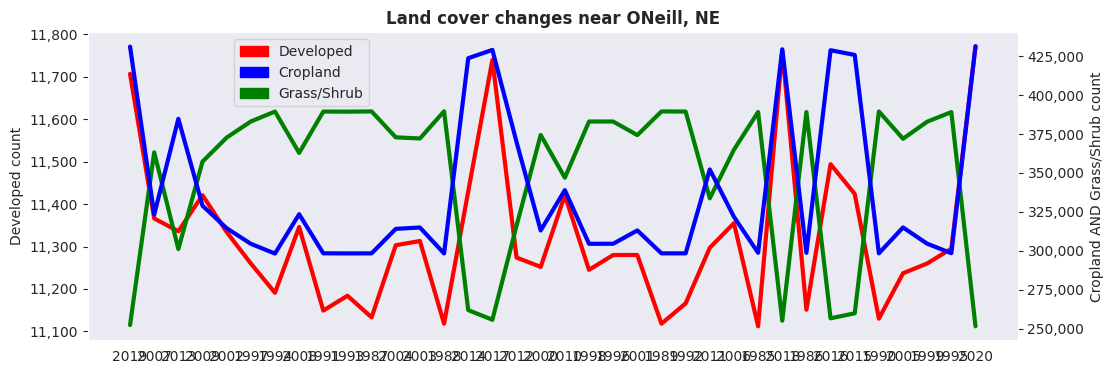

In [8]:
colors = {
    "grass": "green",
    "developed": "red",
    "cropland": "blue"
}

df['year'] = df.t_ranges.apply(lambda x: x[0]['begin'])
sns.set_style("dark")
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(df.year, df["Developed_count"], linewidth=3, color= colors["developed"])
ax.set_ylabel("Developed count")
ax2=ax.twinx()
ax2.plot(df.year, df["Grass/Shrub_count"], linewidth=3, color= colors["grass"])
ax2.plot(df.year, df["Cropland_count"], linewidth=3, color = colors["cropland"])
ax2.set_ylabel("Cropland AND Grass/Shrub count")
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Land cover changes near ONeill, NE", weight="bold")
dev_l = mpatches.Patch(color=colors["developed"], label="Developed")
crp_l = mpatches.Patch(color=colors["cropland"], label="Cropland")
grs_l = mpatches.Patch(color=colors["grass"], label="Grass/Shrub")
ax.legend(handles=[dev_l,crp_l,grs_l], bbox_to_anchor=(0.15, 1))